# Multi-level regression modeling, baby one more time

This notebook provides an introduction to multi-level regression modeling
using [Stan](https://mc-stan.org) and the [CmdStanPy](https://mc-stan.org/cmdstanpy/) interface,
a pure Python3 package for Linux, MacOS, and Windows.
It is based on Chris Fonnesbeck's excellent [A Primer on Bayesian Multilevel Modeling using PyStan](https://mc-stan.org/users/documentation/case-studies/radon.html), which was developed as part of a [Stan workshop](https://statmoddev.stat.columbia.edu/2016/06/09/a-primer-on-bayesian-multilevel-modeling-using-pystan/)  for biomedical statisticians at Vanderbilt University.
The data and models are taken from chapter 12 of the book _Data Analysis Using Regression and Multilevel/Hierarchical Models_, by Andrew Gelman and Jennifer Hill, Cambridge university press, 2006.

A secondary aim of this notebook is to demonstrate best practices of Bayesian data analysis,
which entails careful summaries and visualization of the data, models, and resulting inferences.
To visualize data and inference results we use
[plotnine](https://plotnine.readthedocs.io/en/stable/).
Plotnine is an implementation of a _grammar of graphics_ in Python, based on [ggplot2](https://en.wikipedia.org/wiki/Ggplot2).
A grammar of graphics is a general scheme for data visualization which breaks up graphs into semantic components.
In plotnine, a ggplot object takes as arguments a [pandas](https://pandas.pydata.org/docs/index.html)
DataFrame object and a mapping between graph elements and and Python variables called an "aesthetic".
Geometric objects (geoms) are responsible for the visual representation of data points.
Theme objects control the overall layout and look and feel.

In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *
from cmdstanpy import CmdStanModel

# setup plot look and feel
theme_set(
  theme_grey() + 
  theme(text=element_text(size=10),
        plot_title=element_text(size=14),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8)
       )
)
flip_xlabels = theme(axis_text_x = element_text(angle=90, hjust=1))

# supress warnings from plotnine
import warnings
warnings.filterwarnings('ignore')

## Modeling goal: home radon measurement

Applied statistical modeling starts with the question we are trying to answer and the available data.
We must understand both the data and the analysis goals before proceeding to model building.

The goal of the radon study is to provide homeowners with reasonable estimates
of home radon levels in each of the approximately 3000 counties in the United States,
which will help them make decisions about measuring or remediating the radon in their houses
based on the best available knowledge of local conditions.  Gelman and Hill write

>Radon is a carcinogen — a naturally occurring radioactive gas whose decay products are also radioactive — known to cause lung cancer in high concentrations and estimated to cause several thousand lung cancer deaths per year in the United States. The distribution of radon levels in U.S. homes varies greatly, with some houses having dangerously high concentrations. In order to identify the areas with high radon exposures, the Environmental Protection Agency coordinated radon measurements in a random sample of more than 80,000 houses throughout the country.

[Radon gas](https://en.wikipedia.org/wiki/Radon) is a product of the slow decay of uranium into lead.  Due to local differences in geology, the level of exposure to radon gas differs from place to place. A common source is uranium-containing minerals in the ground, and therefore it accumulates in subterranean areas such as basements.

![How radon enters the home](radon_entry.png)

The [EPA radon map](https://www.epa.gov/sites/default/files/2015-07/documents/zonemapcolor.pdf) shows the counties of the US, color coded by radon level - red for the highest risk, orange for moderate, and yellow for low.

![EPA radon map](epa_radon_map.png)

## Study data:  item-level radon, county-level soil uranium levels


Gelman and Hill chapter 12 is based on work done by [Price and Gelman](http://www.stat.columbia.edu/~gelman/research/published/sagtufinal.pdf).
The data comes from EPA surveys at the state and national level carried out in the 1990s.
Although there are a total of 120K home radon measurements, there are 3000 counties in the US.  The per-county measurements follow the population density; there are few or no measurements for sparsely populated counties, i.e.
rural counties and correspondingly more for metropolitan counties.

The data for the radon study are available from the Gelman and Hill [ARM website](http://www.stat.columbia.edu/~gelman/arm/examples/radon/), together with the R scripts
used to produce the examples in the book.
The study data is in two files.

- Home radon measurements, and the floor (ground or basement) where measured from an EPA survey conducted in 1992.
The survey data is in file http://www.stat.columbia.edu/~gelman/arm/examples/radon/srrs2.dat.

- County level measurements of soil uranium levels in parts per million.
The soil uranium data is in file http://www.stat.columbia.edu/~gelman/arm/examples/radon/cty.dat

_Note_: The full EPA dataset has been [archived separately](http://www.stat.columbia.edu/~gelman/arm/examples/radon_complete/).

We have downloaded and renamed these files.
File `srrs2.dat` is available as  [raw_radon.csv](raw_radon.csv) and
file `cty.dat` is available as [raw_uranium.csv](raw_uranium.csv).
These names are informative and will sort together in a directory listing.


#### Data Preprocessing

Data preparation consists of the following

1. Merge the county-level soil uranium level measurment into the house-level radon data.

2. Put both outcome and predictors on the log scale, following Gelman and Hill, chapter 4, section 12.

3. Restrict the dataset to Minnesota.


There are many tedious steps in assembling the data; these are shown in full detail in [Appendix A](#appendix_a).
The Minnesota data is in file [mn_radon.json](mn_radon.json).

In [2]:
mn_radon = pd.read_json(r'mn_radon.json')
mn_radon[:7]

,state,floor,county,fips,log_radon,log_uranium,county_code
0,MN,1,AITKIN,27001,0.788457,-0.689048,0
1,MN,0,AITKIN,27001,0.788457,-0.689048,0
2,MN,0,AITKIN,27001,1.064711,-0.689048,0
3,MN,0,AITKIN,27001,0.000000,-0.689048,0
4,MN,0,ANOKA,27003,1.131402,-0.847313,1
5,MN,0,ANOKA,27003,0.916291,-0.847313,1
6,MN,0,ANOKA,27003,0.405465,-0.847313,1


### Prelminary data analysis

The goal of our analysis is to estimate the home radon level; therefore the outcome variable of interest is `log_radon`.
We use the [pandas.DataFrame.describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) function to get summary statistics over the observed outcome `log_radon`.

In [3]:
print(f'log_radon summary statistics\n{mn_radon["log_radon"].describe()}')

log_radon summary statistics
count    919.000000
mean       1.224623
std        0.853327
min       -2.302585
25%        0.641854
50%        1.280934
75%        1.791759
max        3.875359
Name: log_radon, dtype: float64


**Relationship between radon and floor**

From the above diagram, we know that radon comes from the soil, therefore the floor level on which the measurement was taken should be a good predictor of the observed radon level. This is coded as "0" for basement and "1" for ground floor level.  Most of the homes in the survey have a basement level.

In [4]:
for c,v in zip(range(2), [round(x/919*100) for x in mn_radon.groupby(['floor']).size()]):
    print(f'{v}% observations taken on floor {c}')

83% observations taken on floor 0
17% observations taken on floor 1


The [plotnine geom_histogram](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_histogram.html) provides a visualization of the distribution of home radon measurements in the survey dataset.
We use plotnine's [facet_grid](https://plotnine.readthedocs.io/en/stable/generated/plotnine.facets.facet_grid.html#plotnine.facets.facet_gridplot ) to make separate plots for measurements taken in the basement level (floor 0) and ground floor level (floor 1).

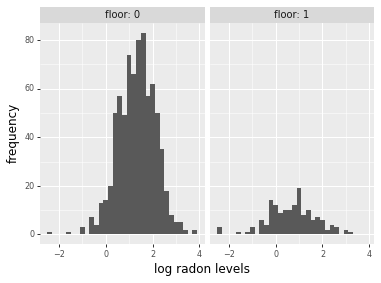

<ggplot: (8788883942623)>

In [5]:
ggplot(mn_radon, aes('log_radon')) + geom_histogram(binwidth=0.2) +\
    xlab("log radon levels") + ylab("frequency") + theme(figure_size=(10,4)) +\
    facet_grid(facets='~ floor', labeller='label_both')

The plotnine [plotnine geom_point](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_point.html) plots two variables as (x, y) points.  In the following plots, we always plot `log_radon` on the y axis, since it is the outcome variable.

We plot the log_radon levels by floor and add jitter to see the relative difference in the measurements and number of observations taken by floor.  The plot shows that a) there are far more measurements taken in the basement than on the ground floor and b) overall, the radon measurements are higher in the basement than on the ground floor, (as expected).

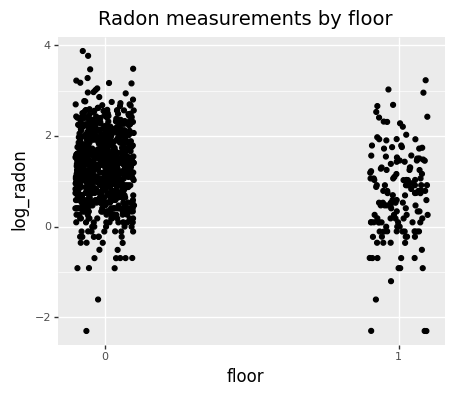

<ggplot: (8788862455007)>

In [6]:
ggplot(mn_radon, aes('floor', 'log_radon')) + geom_jitter(width=0.1) + theme(figure_size=(5,4)) +\
    ggtitle("Radon measurements by floor") + scale_x_continuous(breaks=range(0,2), minor_breaks=[])

**Relationship between home radon and county-level soil uranium**

At the county level we have many home radon measurements from the relatively few counties with metropolitan areas, and very few home radon measurements from the rest.

summary stats for per-county observations
count     85.000000
mean      10.811765
std       18.670383
min        1.000000
25%        3.000000
50%        5.000000
75%       10.000000
max      116.000000
Name: county, dtype: float64



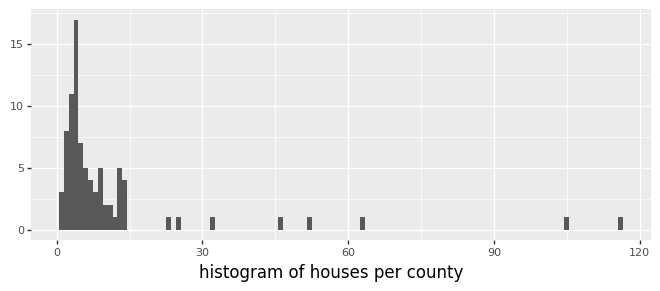

<ggplot: (8788828677114)>

In [7]:
obs_per_county = mn_radon['county'].value_counts(sort=False)
print(f'summary stats for per-county observations\n{obs_per_county.describe()}\n')
ggplot(obs_per_county.to_frame(name='num_obs'), aes('num_obs')) + geom_histogram(binwidth=1) +\
    xlab("histogram of houses per county") + ylab("") + theme(figure_size=(8,3))

At the county-level, we have information on the soil uranium level.  We plot the number of observations by soil uranium.

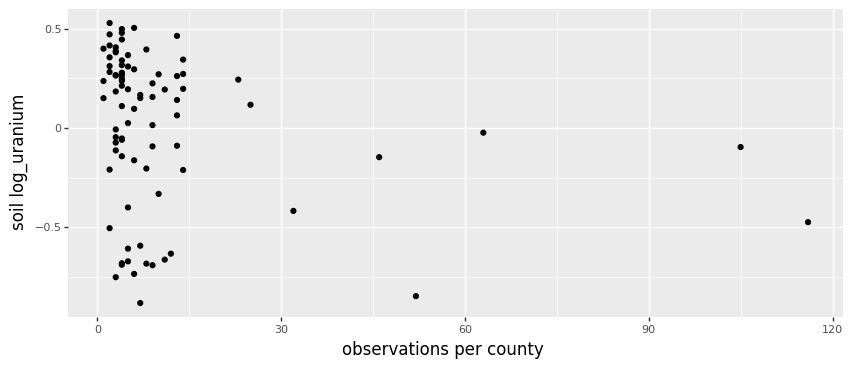

<ggplot: (8788884060691)>

In [8]:
uranium_per_county = mn_radon.drop_duplicates(subset='log_uranium')['log_uranium']
county_dict = {"obs": obs_per_county.values, "uranium": uranium_per_county.values}
county_df = pd.DataFrame(county_dict)
# plot, keeping uranium level on y axis
ggplot(county_df, aes(x=obs_per_county.values, y=uranium_per_county.values)) + \
    geom_point() + \
    ylab("soil log_uranium") + xlab("observations per county") + \
    theme(figure_size=(10,4))


We plot the relationship between soil uranium level and the home radon measurement, faceted by floor.
Because the soil uranium level measurement is the same for all homes in a county, for counties with many houses, i.e., metropolitan areas, the plot shows distinct vertical bands.

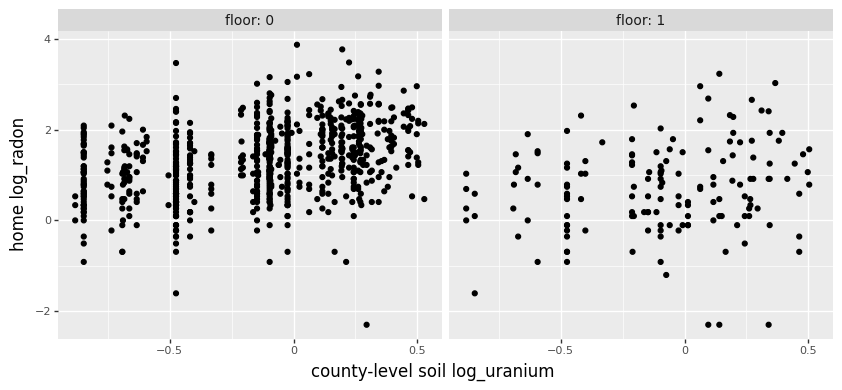

<ggplot: (8788828685005)>

In [9]:
ggplot(mn_radon, aes('log_uranium', 'log_radon')) + geom_point() +\
    ylab("home log_radon") + xlab("county-level soil log_uranium") + theme(figure_size=(10,4)) +\
    facet_grid(facets='~ floor', labeller='label_both')

For many counties, all observations were taken at the basement level.

In [10]:
print(f'Counties with observations from both basement and ground floors: \
{len(mn_radon[mn_radon["floor"] == 1]["county"].value_counts())}')

print(f'Total number of counties: {mn_radon.county.nunique()}')

Counties with observations from both basement and ground floors: 60
Total number of counties: 85


To see whether or not the soil uranium level might be a good predictor of the home radon measurements, we plot the per-county activity levels, ordered by uranium level per county, descending.  The resulting plot is inconclusive.

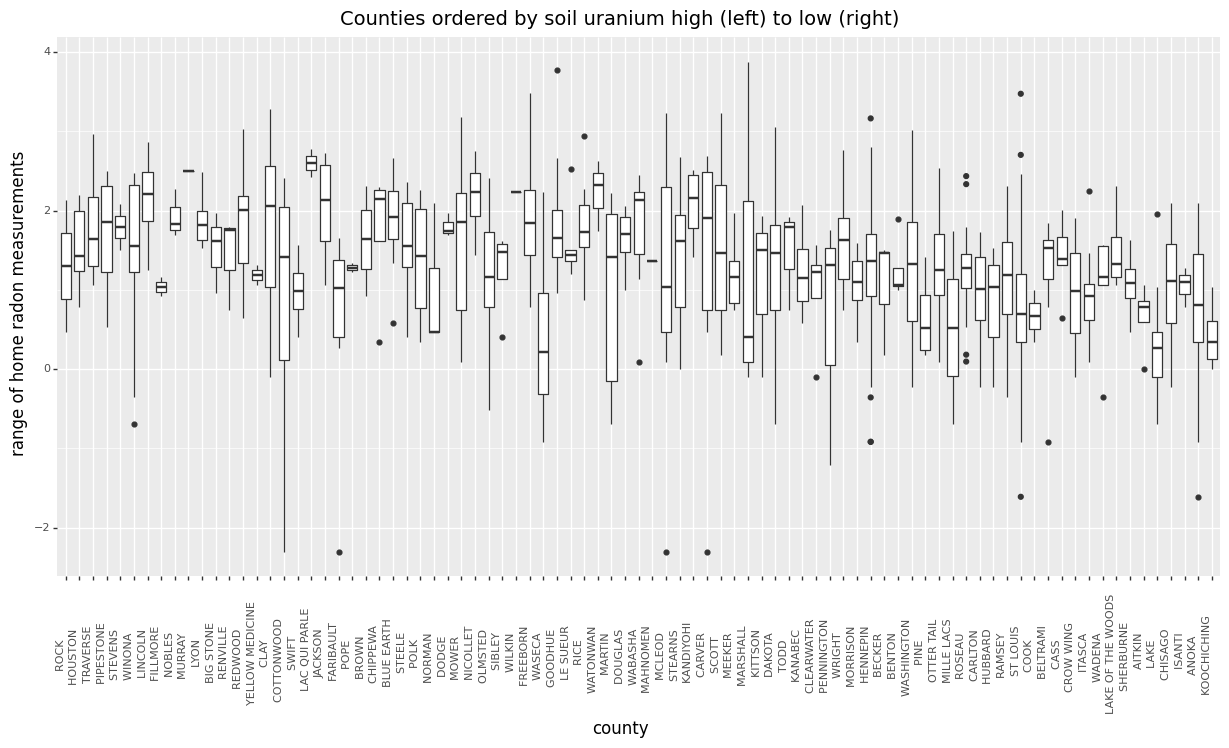

<ggplot: (8788811923327)>

In [11]:
uranium_sorted = mn_radon.drop_duplicates(subset='log_uranium').filter(
    items=['county', 'log_uranium']
).sort_values(by='log_uranium', axis='index', ascending=False).reset_index()
ggplot(mn_radon, aes('county', 'log_radon')) + \
    geom_boxplot() +  flip_xlabels + \
    scale_x_discrete(limits=uranium_sorted['county']) + \
    ggtitle("Counties ordered by soil uranium high (left) to low (right)") + \
    ylab("range of home radon measurements") + \
    theme(figure_size=(15,7)) 

Now that we have taken a look at the essential characteristics of the data, we can start building models.

## Linear regression review (chapters 2 and 3 of Gelman and Hill)

> Linear regression is a method that summarizes how the average values of a numerical outcome variable vary over subpopulations defined by linear functions of predictors. ... Regression can be used to predict an outcome given a linear function of these predictors, and regression coefficients can be thought of as comparisons across predicted values or as comparisons among averages in the data. </br>_Gelman and Hill, chapter 3_

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression#Formulation) models the relationship between a scalar response and one or more explanatory variables.

<img width="190" alt="Linear least squares example2" align="right" style="vertical-align:middle;margin:0px 50px"
     src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Linear_least_squares_example2.png/190px-Linear_least_squares_example2.png">

In linear regression, the observations (red) are assumed to be the result of random deviations (green) from an underlying relationship (blue) between a dependent variable (y) and an independent variable (x).

A [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) is a model which relates
a pair of sample points, an  _independent variable_ x, and a _dependent variable_ y.
The adjective simple refers to the fact that the outcome variable is related to a single predictor.
The model finds a linear function (a non-vertical straight line) that,
as accurately as possible, predicts the dependent variable values as a function of the independent variable.  (Geometry review: a straight line is defined by its _intercept_ on the x-axis and _slope_, i.e. $y = a + b x$)

**Linear regression:  two ways to write the model**

The goal of inference is to learn from incomplete or imperfect data.
In the simple linear regression model, the error term $\epsilon$ accounts for imperfect measurments of the data.

$
y_i = \alpha \, + {\beta}\,x_i + {\epsilon}
$


We can generalize this model to handle data with more than one predictor

$
y_i = \beta\,X_i  + {\epsilon}_i
$

Now the intercept is included in the vector $\beta$ and a corresponding column of $1$s is added to the predictors.
This is equivalent to

$
y_i = {\beta}_1 X_{i1}\, + \, ... \, +  \, {\beta}_k X_{ik} \, +  \, {\epsilon}_i \ \ \ \mathrm{for}\ i=1, ..., n
$

where the errors ${\epsilon}_i$ have independent normal distributions with mean $0$ and standard deviation $\theta$.

An equivalent representation is

$
y_i ∼ \mathrm{N}(\beta\,\mathrm{X}_i,\, \sigma^2), \ \ \ \mathrm{for}\ i=1, ..., n
$

## Linear regression models in Stan

The simplest linear regression model has a single predictor and a slope and intercept coefficient, and normally distributed noise.  It is the first model discussed in the [Stan User's Guide Regression Models chapter](https://mc-stan.org/docs/stan-users-guide/linear-regression.html).

```
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
}
```

When modeling data which has group-level structure, as is the case here, where radon measurements are located within counties, there are only two possible single-level linear models: _complete pooling_ and _no pooling_.

**Complette pooling**

The complete pooling model treats all counties in Minnesota as equivalent.
This is exactly the Stan model above.
It has two co-efficients, $\alpha$ and $\beta$, the intercept and slope of the regression line, respectively.

$
y_i = \alpha \, + {\beta}\,x_i + {\epsilon}
$

For the Minnesota data, we plot the predictor (floor) on the x axis and the outcome (log_radon) on the y axis, and use [plotnine.geom.geom_smooth](https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_smooth.html#plotnine.geoms.geom_smooth) to fit a regression line.  The solid black line is the regression line, and the grey margins indicate the amount of variance.

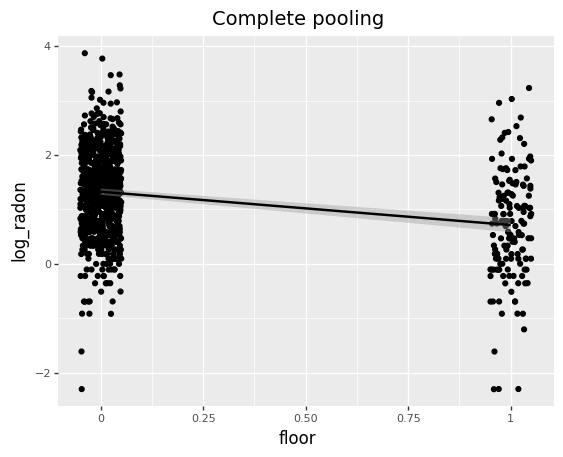

<ggplot: (8788795187167)>

In [12]:
ggplot(mn_radon, aes('floor', 'log_radon')) + geom_jitter(width=0.05) + geom_smooth(method='lm') +\
 ggtitle("Complete pooling")

**No pooling**

The no-pooling model treats each county in Minnesota as independent and for each county, we fit the above model to just the observations from that county.
We can accomplish this by faceting the above plot.  The resulting facets show the increased variance (width of gray area around trend line). 

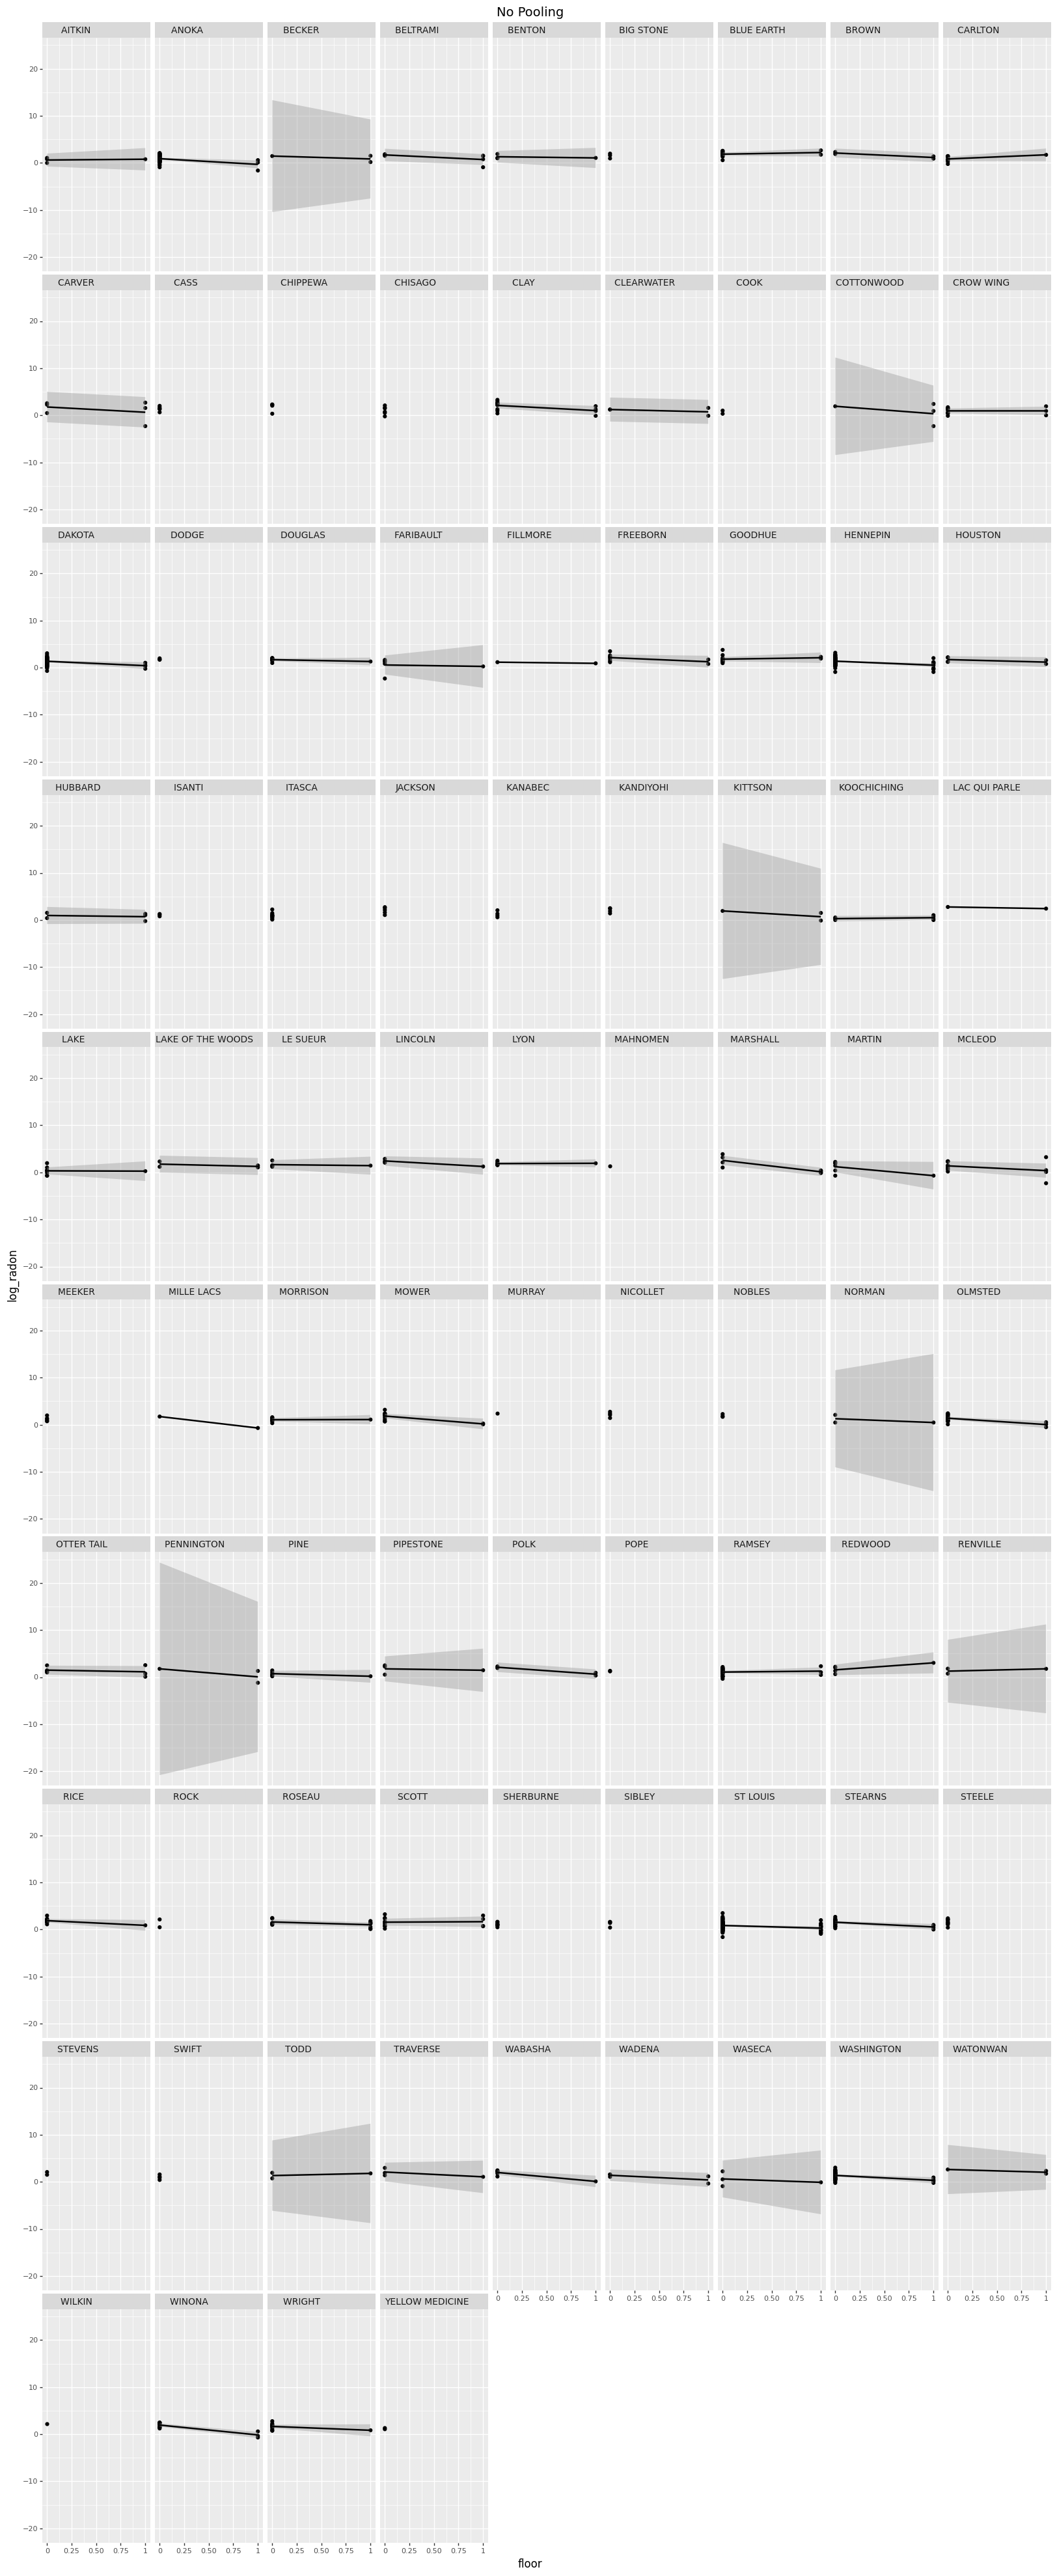

<ggplot: (8788795204349)>

In [13]:

ggplot(mn_radon, aes('floor', 'log_radon')) + geom_point() + geom_smooth(method='lm') +\
   facet_wrap('~county', ncol=9) + theme(figure_size=(20,50)) + ggtitle("No Pooling")

This regression model is a non-starter for the 25 counties where all measurements were taken on the basement level.
For the remaining counties, most of which have very few measurments, in several instances, e.g., counties "Lyon" and "Redwood", the regression line between floor 0 and 1 has a positvie slope; in contrast to the complete pooling model.
This goes against what we know about how radon enters the home.

The no-pooling model, given sparse data, is a non-starter, however the complete-pooling model overlooks structure in the data, i.e., houses are located within counties which have different geological profiles.

## Multilevel models

Multilevel models are extensions of regression in which data are structured in groups and coefficients can vary by group, and both the group-level and individual level co-efficients are modeled.

For a simple linear regression model with a single predictor, the complete-pooling model
estimates two parameters:  the intercept and slope of the regression line.
In a multilevel regression model, we introduce modeled group-level parameters
which provide partial pooling of information across the groups.
There are three possible ways to pool information:

- varying slope, single intercept

- single slope, varying intercept

- individual slope, individual intercept

As we add more predictors to the model, the number of modeling choices increases.

**Model 2A:  verying slope, single intercept** same baseline, different counties have different floor effects

**Model 2B: single slope varying intercept** floor effect is the same, different counties have different baseline

**Model 2C: varying slope, varying intercept** lots of little indices everywhere

<a id='appendix_A'></a>
## Appendix A:  Data Preprocessing

We use pandas to read each CSV file into a [pandas DataFrame](https://pandas.pydata.org/docs/reference/frame.html),
which is a tabular data structure, similar that an [R data.frame](https://stat.ethz.ch/R-manual/R-devel/library/base/html/data.frame.html) or a SQL database table.
There are many possible ways to manipulate tabular datasets in Python.
We borrow code from both Chris Fonnesbeck's PyStan primer and a similar notebook
on [multilevel modeling with TensorFlow Probability]( https://notebook.community/tensorflow/probability/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer), section 3.  Following the latter, we encapsulate step 2 into a function which can be used to restrict the dataset to any state.



#### Extract relevant columns from CSV as pandas DataFrame

We leverage the [pandas.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function
to extract the information we need from the raw CSV files with the following non-default arguments

* parameter `usecols` allows us to extract just the relevant columns for this analysis.
* parameter `skipinitialspace` strips out initial whitespace from the data.

Once instantiated, we call the [convert_dtypes method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.convert_dtypes.html) on the newly instantiated dataframe in order to ensure that we can do merge and join operations on all columns.

In [14]:
df_radon = pd.read_csv(r'raw_radon.csv',
    usecols=['state', 'stfips', 'floor', 'activity', 'county', 'cntyfips'],
    skipinitialspace=True,    # CSV file has spaces after delimiter, ignore them
).convert_dtypes()
print(f'Total records: {len(df_radon)}')
df_radon[:3]

Total records: 12777


,state,stfips,floor,activity,cntyfips,county
0,AZ,4,1,0.3,1,APACHE
1,AZ,4,9,0.6,1,APACHE
2,AZ,4,1,0.5,1,APACHE


In [15]:
df_uranium = pd.read_csv(r'raw_uranium.csv',
                        usecols=['stfips', 'ctfips', 'st', 'cty', 'Uppm'],
                        skipinitialspace=True,
                        ).drop_duplicates().convert_dtypes()
df_uranium[:3]

,stfips,ctfips,st,cty,Uppm
0,1,1,AL,AUTAUGA,1.78331
1,1,3,AL,BALDWIN,1.38323
2,1,5,AL,BARBOUR,2.10105


#### Combine datasets

[FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) are numbers which uniquely identify geographic areas. Both datasets have codes for the state and county ids, but these need to be combined to get a national-level county FIPS code.

First we add this common code to both tables, then we use it to merge the county-level soil uranium levels into the radon survey data.

In [16]:
df_radon['fips'] = df_radon.stfips*1000 + df_radon.cntyfips
df_uranium['fips'] = df_uranium.stfips*1000 + df_uranium.ctfips

df_radon = df_radon.merge(df_uranium[['fips', 'Uppm']], on='fips')
df_radon[:3]

,state,stfips,floor,activity,cntyfips,county,fips,Uppm
0,AZ,4,1,0.3,1,APACHE,4001,2.26437
1,AZ,4,9,0.6,1,APACHE,4001,2.26437
2,AZ,4,1,0.5,1,APACHE,4001,2.26437


#### Put data on log scale

Following Gelman and Hill chapter 4, section 4, we work with data on the log scale.
We know from geology that both radon measurements and soil uranium levels are always greater than zero,
however a few radon measurements in the EPA dataset are 0.
In order to be able to work with these measurements on the log scale, we replace 0 with 0.1,
which corresponds to a low radon level (following Gelman and Hill).

In [17]:
df_radon['radon'] = df_radon.activity.apply(lambda x: x if x > 0. else 0.1)
df_radon['log_radon'] = np.log(df_radon['radon'])

df_radon['uranium'] = df_radon.Uppm.apply(lambda x: x if x > 0. else 0.1)
df_radon['log_uranium'] = np.log(df_radon['uranium'])
df_radon[:3]

,state,stfips,floor,activity,cntyfips,county,fips,Uppm,radon,log_radon,uranium,log_uranium
0,AZ,4,1,0.3,1,APACHE,4001,2.26437,0.3,-1.203973,2.26437,0.817297
1,AZ,4,9,0.6,1,APACHE,4001,2.26437,0.6,-0.510826,2.26437,0.817297
2,AZ,4,1,0.5,1,APACHE,4001,2.26437,0.5,-0.693147,2.26437,0.817297


#### Cleanup (optional)

Remove the columns which contain redundant information.  (_Note_: we could also drop columns 'radon' and 'uranium' since we'll be working on the log scale.)

In [18]:
df_radon.drop(columns=['stfips', 'activity', 'cntyfips', 'Uppm', 'radon', 'uranium'], inplace=True)

In [19]:
df_radon[:3]

,state,floor,county,fips,log_radon,log_uranium
0,AZ,1,APACHE,4001,-1.203973,0.817297
1,AZ,9,APACHE,4001,-0.510826,0.817297
2,AZ,1,APACHE,4001,-0.693147,0.817297


#### Helper function: get one state's worth of data

It is straightforward to subset the radon data at the state level.
Following the TensorFlow Probability notebook, we define a function which given a state code and a dataframe
returns a dataframe for that state.

We use conditional expressions to [filter specific rows of a dataframe](https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html#how-do-i-filter-specific-rows-from-a-dataframe).
We also create a 0-based indices for the state-level individual observations and counties.
This makes it easy to iterate through and plot the data.

In [20]:
def state_filter(df_radon: pd.DataFrame, state: str) -> pd.DataFrame:
    df_radon_st = df_radon[df_radon['state']==state].reset_index(drop=True)
    counties = sorted(df_radon_st.county.unique())
    df_radon_st['county_code'] = df_radon_st.county.astype(pd.api.types.CategoricalDtype(categories=counties)).cat.codes
    return df_radon_st

In [21]:
df_radon_mn = state_filter(df_radon, 'MN')
df_radon_mn[:3]

,state,floor,county,fips,log_radon,log_uranium,county_code
0,MN,1,AITKIN,27001,0.788457,-0.689048,0
1,MN,0,AITKIN,27001,0.788457,-0.689048,0
2,MN,0,AITKIN,27001,1.064711,-0.689048,0


#### Save to JSON file

In [22]:
# uncomment as needed
# df_radon_mn.to_json(r'mn_radon.json')